### 音樂風格分辨器訓練
利用處理好的26維資料集，訓練可辨識音樂風格的分類模型
### Music Style Classifier Training
Train a music genre classification model using the processed 26-dimensional dataset.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# 設定隨機種子
SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)

# 載入資料與預處理
data = pd.read_csv('data_features.csv')
X = data.drop(['filename', 'label'], axis=1).values
y = LabelEncoder().fit_transform(data['label'])

# 標準化 (使用原 notebook 相同邏輯)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 資料分割 (保持原比例)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=SEED)

# 轉換為 PyTorch Dataset
class MusicDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_set = MusicDataset(X_train, y_train)
val_set = MusicDataset(X_val, y_val)
test_set = MusicDataset(X_test, y_test)


In [7]:
class GenreClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),  # 增加第一層神經元
            nn.ReLU(),
            nn.Dropout(0.6),              # 降低Dropout
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

        
    def forward(self, x):
        return self.layers(x)

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GenreClassifier(input_size=X_train.shape[1]).to(device)

# 訓練參數設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # 降低學習率並添加L2正則化
batch_size = 256  # 增加批次大小
epochs = 500

# 早停機制
best_val_acc = 0
patience = 20  # 增加耐心值
counter = 0

Epoch 1: Train Loss = 2.0800, Train Acc = 0.2558, Val Loss = 1.6945, Val Acc = 0.3393
Epoch 2: Train Loss = 1.6578, Train Acc = 0.3758, Val Loss = 1.4406, Val Acc = 0.4714
Epoch 3: Train Loss = 1.4763, Train Acc = 0.4606, Val Loss = 1.3205, Val Acc = 0.5157
Epoch 4: Train Loss = 1.3920, Train Acc = 0.5036, Val Loss = 1.2392, Val Acc = 0.5655
Epoch 5: Train Loss = 1.3215, Train Acc = 0.5328, Val Loss = 1.1642, Val Acc = 0.5969
Epoch 6: Train Loss = 1.2403, Train Acc = 0.5710, Val Loss = 1.1000, Val Acc = 0.6238
Epoch 7: Train Loss = 1.1815, Train Acc = 0.5887, Val Loss = 1.0498, Val Acc = 0.6398
Epoch 8: Train Loss = 1.1484, Train Acc = 0.6017, Val Loss = 1.0146, Val Acc = 0.6447
Epoch 9: Train Loss = 1.1074, Train Acc = 0.6138, Val Loss = 0.9901, Val Acc = 0.6597
Epoch 10: Train Loss = 1.0692, Train Acc = 0.6362, Val Loss = 0.9366, Val Acc = 0.6692
Epoch 11: Train Loss = 1.0449, Train Acc = 0.6448, Val Loss = 0.9255, Val Acc = 0.6801
Epoch 12: Train Loss = 1.0182, Train Acc = 0.6534, V

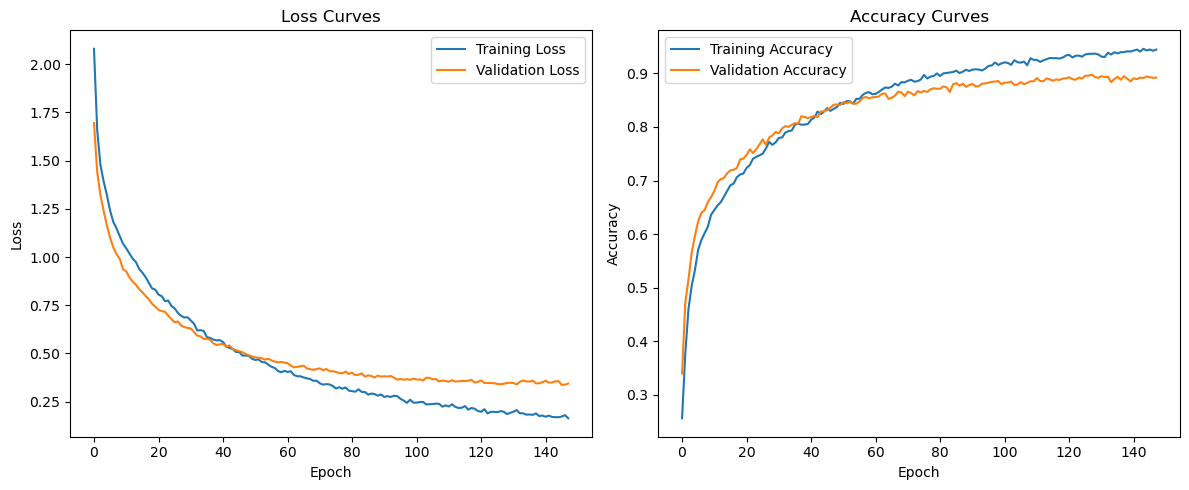

測試集準確率: 0.8960


C:\Users\user\AppData\Local\Temp\ipykernel_8624\2391428193.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [54]:
# 記錄每個 epoch 的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 訓練循環
for epoch in range(epochs):
    model.train()
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # 訓練階段
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)
    
    # 驗證階段
    model.eval()
    val_loader = DataLoader(val_set, batch_size=batch_size)
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    
    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}')
    
    # 早停檢查
    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("早停觸發！")
            break

# 繪製訓練過程圖表
plt.figure(figsize=(12, 5))

# 繪製損失曲線
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 繪製準確率曲線
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 測試模型
model.load_state_dict(torch.load('best_model.pth'))
test_loader = DataLoader(test_set, batch_size=batch_size)
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'測試集準確率: {correct / total:.4f}')

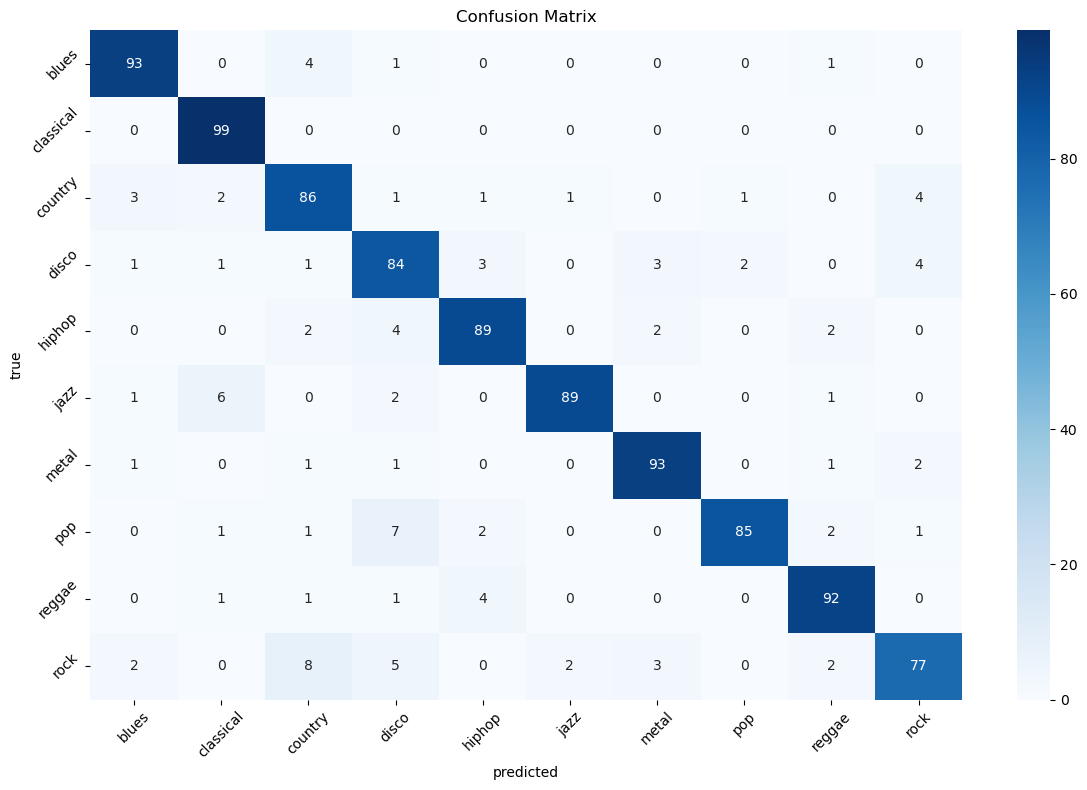

blues 類別準確率: 0.9394
classical 類別準確率: 1.0000
country 類別準確率: 0.8687
disco 類別準確率: 0.8485
hiphop 類別準確率: 0.8990
jazz 類別準確率: 0.8990
metal 類別準確率: 0.9394
pop 類別準確率: 0.8586
reggae 類別準確率: 0.9293
rock 類別準確率: 0.7778


In [55]:
# 混淆矩陣分析
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 在測試集上進行預測
model.eval()
test_loader = DataLoader(test_set, batch_size=batch_size)
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 計算混淆矩陣
cm = confusion_matrix(all_labels, all_predictions)

# 獲取類別標籤
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])
class_names = label_encoder.classes_

# 繪製混淆矩陣
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 計算每個類別的準確率
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracy)):
    print(f'{class_name} 類別準確率: {acc:.4f}')